**Step 1: Importing necessary libraries**

In [15]:
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

**Step 2: Web scraping portion**

In [2]:
# Initialize the web driver
driver = webdriver.Chrome()

# Open the webpage
url = "https://www.treasurydirect.gov/auctions/announcements-data-results/announcement-results-press-releases/"
driver.get(url)
driver.implicitly_wait(6)  # Wait for up to 6 seconds for elements to appear

# Click into Year list
element = driver.find_element(By.ID, "dropdownlistContentjqYearList")
element.click()
time.sleep(4)

# Click into '2022' year
option_2022 = driver.find_element(By.XPATH, '//*[@id="listitem1innerListBoxjqYearList"]/span')
option_2022.click()
time.sleep(4)

# Click submit button
submit_button = driver.find_element(By.ID, "jqButtonYear")
submit_button.click()
time.sleep(5)

# Click into Bills
Bill = driver.find_element(By.XPATH, '//*[@id="row0jqxGrid"]/div[1]')
Bill.click()
time.sleep(2)

# Click into 4 week term for bills
Bill4WeekTerm = driver.find_element(By.XPATH, '//*[@id="row1jqxGrid"]/div[2]')
Bill4WeekTerm.click()
time.sleep(2)

# Click into 8 week term for bills
Bill8WeekTerm = driver.find_element(By.XPATH, '//*[@id="row54jqxGrid"]/div[2]')
Bill8WeekTerm.click()
time.sleep(2)

# Click into 17 week term for bills
Bill17WeekTerm = driver.find_element(By.XPATH, '//*[@id="row107jqxGrid"]/div[2]')
Bill17WeekTerm.click()
time.sleep(2)

# Click into 13 week term for bills
Bill13WeekTerm = driver.find_element(By.XPATH, '//*[@id="row119jqxGrid"]/div[2]')
Bill13WeekTerm.click()
time.sleep(2)

# Click into 26 week term for bills
Bill26WeekTerm = driver.find_element(By.XPATH, '//*[@id="row172jqxGrid"]/div[2]')
Bill26WeekTerm.click()
time.sleep(2)

# Click into 52 week term for bills
Bill52WeekTerm = driver.find_element(By.XPATH, '//*[@id="row225jqxGrid"]/div[2]')
Bill52WeekTerm.click()
time.sleep(2)

# Click into Notes
Note = driver.find_element(By.XPATH, '//*[@id="row239jqxGrid"]/div[1]')
Note.click()
time.sleep(2)

# Click into 7 year term for notes
Note7YearTerm = driver.find_element(By.XPATH, '//*[@id="row240jqxGrid"]/div[2]')
Note7YearTerm.click()
time.sleep(2)

# Click into 5 year term for notes
Note5YearTerm = driver.find_element(By.XPATH, '//*[@id="row253jqxGrid"]/div[2]')
Note5YearTerm.click()
time.sleep(2)

# Click into 2 year term for notes
Note2YearTerm = driver.find_element(By.XPATH, '//*[@id="row266jqxGrid"]/div[2]')
Note2YearTerm.click()
time.sleep(2)

# Click into 3 year term for notes
Note3YearTerm = driver.find_element(By.XPATH, '//*[@id="row279jqxGrid"]/div[2]')
Note3YearTerm.click()
time.sleep(2)

# Click into 10 year term for notes
Note10YearTerm = driver.find_element(By.XPATH, '//*[@id="row292jqxGrid"]/div[2]')
Note10YearTerm.click()
time.sleep(2)

# Locate the table-view to scrape through
table = driver.find_element(By.XPATH, '//*[@id="contentjqxGrid"]/div[2]')

# Find all XML file links within the table and with div[13] in their XPath, spanning from "row2" to "row304". This is because the XML file on 'Competitive Results' is captured under div[13] and rows 2 to 304 are the rows spanning Bills and Notes
xml_links = table.find_elements(By.XPATH, './/div[contains(@id, "row") and contains(@id, "jqxGrid")][position() >= 2 and position() <= 305]/div[13]/div/div/a[contains(text(), "XML")]')

**Step 3: Iterating over each xml_link to scrape the data, storing data onto data_list**

In [3]:
# Create an empty list to collect data
data_list = []
# count = 0

announcement_fields = ['SecurityTermWeekYear', 'SecurityType', 'CUSIP', 'AnnouncementDate', 'AuctionDate']

for xml_link in xml_links:
    href = xml_link.get_attribute("href")
    response = requests.get(href)
    # print("doing count number" + str(count))
    # count += 1
    
    if response.status_code == 200:
        xml_data = response.text
        root = ET.fromstring(xml_data)
        
        if not data_list:
            field_names = [elem.tag for elem in root.find('.//AuctionResults')]
            data_list.append(field_names)
            data_list = data_list + announcement_fields

        # Extract data from <AuctionResults> in XML
        data_results = [root.find('.//AuctionResults/' + field_name).text for field_name in field_names]
        
        # Extract data from <AuctionAnnouncement> in XML
        data_announcement = [root.find('.//AuctionAnnouncement/' + field_name).text for field_name in announcement_fields]
        
        data = data_results + data_announcement
        data_list.append(data)

**Step 4: Showcasing Dataframe**

In [4]:
df = pd.DataFrame(data_list, columns=field_names + announcement_fields)
df = df.iloc[6:]
df = df.reset_index(drop=True)

# Check if all values in a column are None and drop it if True
for column in df.columns:
    if df[column].isnull().all():
        df = df.drop(columns=column)
        
df = df[list(df.columns[-5:]) + list(df.columns[:-5])]

# List of columns to exclude from conversion to numeric form
columns_to_exclude = ['SecurityTermWeekYear', 'SecurityType', 'CUSIP', 'AnnouncementDate', 'AuctionDate', 'ReleaseTime', 'HighAllocationPercentage', 'LowDiscountRate', 'HighDiscountRate', 'MedianDiscountRate', 'LowYield', 'HighYield', 'MedianYield', 'HighPrice', 'AccruedInterest', 'StandardInterestPayment', 'InterestRate', 'OriginalCUSIP', 'ResultsPDFName']
columns_to_convert = [col for col in df.columns if col not in columns_to_exclude]

# Convert the specified columns to integers
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Custom function to format integers with commas
def format_integers_with_commas(value):
    if isinstance(value, int):
        return '{:,}'.format(value)
    return value

df = df.map(format_integers_with_commas)
df['AnnouncementDate'] = pd.to_datetime(df['AnnouncementDate'], format='%Y-%m-%d')
df['AuctionDate'] = pd.to_datetime(df['AuctionDate'], format='%Y-%m-%d')
        
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.reset_option('^display.', silent=True)
display(df)

,SecurityTermWeekYear,SecurityType,CUSIP,AnnouncementDate,AuctionDate,PrimaryDealerTendered,PrimaryDealerAccepted,DirectBidderTendered,DirectBidderAccepted,IndirectBidderTendered,IndirectBidderAccepted,CompetitiveTendered,CompetitiveAccepted,NonCompetitiveAccepted,SOMATendered,SOMAAccepted,FIMATendered,FIMAAccepted,TotalTendered,TotalAccepted,BidToCoverRatio,ReleaseTime,AmountAcceptedBelowLowRate,HighAllocationPercentage,LowDiscountRate,HighDiscountRate,MedianDiscountRate,LowYield,HighYield,MedianYield,HighPrice,AccruedInterest,StandardInterestPayment,InterestRate,OriginalCUSIP,TreasuryDirectAccepted,InvestmentRate,ResultsPDFName
0,4-WEEK,BILL,912796ZM4,2022-12-27,2022-12-29,"92,380,000,000","19,838,100,000","1,200,000,000","700,000,000","23,018,251,700","22,425,656,700","116,598,251,700","42,963,756,700","1,906,341,900","943,870,400","943,870,400","130,000,000","130,000,000","119,578,464,000","45,943,969,000",2.64,11:32,5,54.81,3.300,3.830,3.650,None,None,None,99.702111,None,None,None,None,"1,521,383,800",3.895,R_20221229_2.pdf
1,4-WEEK,BILL,912796ZL6,2022-12-20,2022-12-22,"92,350,000,000","12,651,562,500","1,050,000,000","350,000,000","34,122,723,900","29,885,186,400","127,522,723,900","42,886,748,900","2,013,339,200","1,219,493,100","1,219,493,100","100,000,000","100,000,000","130,855,556,200","46,219,581,200",2.88,11:32,5,62.65,3.400,3.610,3.500,None,None,None,99.719222,None,None,None,None,"1,563,715,200",3.670,R_20221222_2.pdf
2,4-WEEK,BILL,912796ZK8,2022-12-13,2022-12-15,"98,030,000,000","10,509,850,000","1,600,000,000","800,000,000","40,023,242,500","31,283,242,500","139,653,242,500","42,593,092,500","2,075,923,100","1,210,543,000","1,210,543,000","331,000,000","331,000,000","143,270,708,600","46,210,558,600",3.16,11:32,5,78.97,3.250,3.780,3.620,None,None,None,99.706000,None,None,None,None,"1,544,378,100",3.844,R_20221215_2.pdf
3,4-WEEK,BILL,912796ZJ1,2022-12-06,2022-12-08,"95,256,000,000","12,557,865,200","1,600,000,000",0,"43,891,402,100","29,809,822,100","140,747,402,100","42,367,687,300","2,105,660,100","1,476,404,000","1,476,404,000","527,000,000","527,000,000","144,856,466,200","46,476,751,400",3.19,11:31,5,87.02,3.300,3.650,3.645,None,None,None,99.716111,None,None,None,None,"1,590,189,000",3.711,R_20221208_1.pdf
4,4-WEEK,BILL,912796ZH5,2022-11-29,2022-12-01,"97,900,000,000","17,451,800,000","2,300,000,000","1,000,000,000","50,950,103,900","23,329,436,200","151,150,103,900","41,781,236,200","2,413,319,000","1,247,364,500","1,247,364,500","806,000,000","806,000,000","155,616,787,400","46,247,919,700",3.43,11:31,5,66.84,3.600,3.950,3.900,None,None,None,99.692778,None,None,None,None,"1,737,498,000",4.017,R_20221201_1.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,10-YEAR,NOTE,91282CEP2,2022-05-04,2022-05-11,"52,812,000,000","4,132,000,000","8,195,000,000","6,545,000,000","28,490,090,000","25,272,055,600","89,497,090,000","35,949,055,600","50,979,700","25,194,106,800","25,194,106,800",0,0,"114,742,176,500","61,194,142,100",2.49,13:02,5,75.08,None,None,None,2.800,2.943,2.850,99.414646,0.07813,14.375,2.875,None,"24,066,700",NaN,R_20220511_2.pdf
288,9-YEAR,NOTE,91282CDY4,2022-04-07,2022-04-12,"51,251,000,000","6,341,930,000","7,484,000,000","5,784,000,000","23,977,205,000","21,864,192,000","82,712,205,000","33,990,122,000","9,955,000","8,110,501,600","8,110,501,600",0,0,"90,832,661,600","42,110,578,600",2.43,13:02,5,66.58,None,None,None,2.570,2.720,2.620,92.751781,3.21133,9.375,1.875,None,"2,960,000",NaN,R_20220412_1.pdf
289,9-YEAR,NOTE,91282CDY4,2022-03-03,2022-03-09,"48,995,000,000","4,670,532,000","9,780,000,000","6,130,000,000","25,270,485,000","23,190,833,000","84,045,485,000","33,991,365,000","8,657,600","5,712,666,700","5,712,666,700",0,0,"89,766,809,300","39,712,689,300",2.47,13:02,5,93.72,None,None,None,1.800,1.920,1.840,99.594019,1.45028,9.375,1.875,None,"2,726,600",NaN,R_20220309_2.pdf
290,10-YE

**Step 5: Visualisations, Insights** 

List of planned graphs (x vs. y format)

*Overall graphs*
1. Announcement Date vs. Total Tendered
2. Annnouncement Date vs. Total Accepted
3. Auction Date vs. Total Tendered
4. Auction Date vs. Total Accepted
5. Bid to Cover Ratio vs. Total Tendered
6. Bid to Cover Ratio vs. Total Accepted

*Bills graphs*
1. Announcement Date vs. Total Tendered
2. Annnouncement Date vs. Total Accepted
3. Auction Date vs. Total Tendered
4. Auction Date vs. Total Accepted
5. Bid to Cover Ratio vs. Total Tendered
6. Bid to Cover Ratio vs. Total Accepted
7. Investment Rate vs. Total Tendered
8. Investment Rate vs. Total Accepted

*Notes graphs*
1. Announcement Date vs. Total Tendered
2. Annnouncement Date vs. Total Accepted
3. Auction Date vs. Total Tendered
4. Auction Date vs. Total Accepted
5. Bid to Cover Ratio vs. Total Tendered
6. Bid to Cover Ratio vs. Total Accepted

*Heat maps (horizontal vs. vertical format)*
1. Different types of tendered amount (take average of amount) vs. Security Term (for Bills)
2. Different types of accepted amount (take average of amount) vs. Security Term (for Bills)
3. Different types of tendered amount (take average of amount) vs. Security Term (for Notes)
4. Different types of accepted amount (take average of amount) vs. Security Term (for Notes)

In [5]:
# This section of code just reinstates the dataframe, however preparing it to be aggregated and used for the planned visualisations

dfVisual = pd.DataFrame(data_list, columns=field_names + announcement_fields)
dfVisual = dfVisual.iloc[6:]
dfVisual = dfVisual.reset_index(drop=True)

# Check if all values in a column are None and drop it if True
for column in dfVisual.columns:
    if dfVisual[column].isnull().all():
        dfVisual = dfVisual.drop(columns=column)
        
dfVisual = dfVisual[list(dfVisual.columns[-5:]) + list(dfVisual.columns[:-5])]

# List of columns to exclude from conversion to numeric form
columns_to_exclude = ['SecurityTermWeekYear', 'SecurityType', 'CUSIP', 'AnnouncementDate', 'AuctionDate', 'ReleaseTime', 'HighAllocationPercentage', 'LowDiscountRate', 'HighDiscountRate', 'MedianDiscountRate', 'LowYield', 'HighYield', 'MedianYield', 'HighPrice', 'AccruedInterest', 'StandardInterestPayment', 'InterestRate', 'OriginalCUSIP', 'ResultsPDFName']
columns_to_convert = [col for col in dfVisual.columns if col not in columns_to_exclude]

dfVisual[columns_to_convert] = dfVisual[columns_to_convert].apply(pd.to_numeric, errors='coerce', downcast='integer')
dfVisual[columns_to_convert] = dfVisual[columns_to_convert].apply(pd.to_numeric, errors='coerce')

dfVisual['AnnouncementDate'] = pd.to_datetime(dfVisual['AnnouncementDate'], format='%Y-%m-%d')
dfVisual['AuctionDate'] = pd.to_datetime(dfVisual['AuctionDate'], format='%Y-%m-%d')

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
# pd.reset_option('^display.', silent=True)
display(dfVisual)

,SecurityTermWeekYear,SecurityType,CUSIP,AnnouncementDate,AuctionDate,PrimaryDealerTendered,PrimaryDealerAccepted,DirectBidderTendered,DirectBidderAccepted,IndirectBidderTendered,IndirectBidderAccepted,CompetitiveTendered,CompetitiveAccepted,NonCompetitiveAccepted,SOMATendered,SOMAAccepted,FIMATendered,FIMAAccepted,TotalTendered,TotalAccepted,BidToCoverRatio,ReleaseTime,AmountAcceptedBelowLowRate,HighAllocationPercentage,LowDiscountRate,HighDiscountRate,MedianDiscountRate,LowYield,HighYield,MedianYield,HighPrice,AccruedInterest,StandardInterestPayment,InterestRate,OriginalCUSIP,TreasuryDirectAccepted,InvestmentRate,ResultsPDFName
0,4-WEEK,BILL,912796ZM4,2022-12-27,2022-12-29,92380000000,19838100000,1200000000,700000000,23018251700,22425656700,116598251700,42963756700,1906341900,943870400,943870400,130000000,130000000,119578464000,45943969000,2.64,11:32,5,54.81,3.300,3.830,3.650,None,None,None,99.702111,None,None,None,None,1521383800,3.895,R_20221229_2.pdf
1,4-WEEK,BILL,912796ZL6,2022-12-20,2022-12-22,92350000000,12651562500,1050000000,350000000,34122723900,29885186400,127522723900,42886748900,2013339200,1219493100,1219493100,100000000,100000000,130855556200,46219581200,2.88,11:32,5,62.65,3.400,3.610,3.500,None,None,None,99.719222,None,None,None,None,1563715200,3.670,R_20221222_2.pdf
2,4-WEEK,BILL,912796ZK8,2022-12-13,2022-12-15,98030000000,10509850000,1600000000,800000000,40023242500,31283242500,139653242500,42593092500,2075923100,1210543000,1210543000,331000000,331000000,143270708600,46210558600,3.16,11:32,5,78.97,3.250,3.780,3.620,None,None,None,99.706000,None,None,None,None,1544378100,3.844,R_20221215_2.pdf
3,4-WEEK,BILL,912796ZJ1,2022-12-06,2022-12-08,95256000000,12557865200,1600000000,0,43891402100,29809822100,140747402100,42367687300,2105660100,1476404000,1476404000,527000000,527000000,144856466200,46476751400,3.19,11:31,5,87.02,3.300,3.650,3.645,None,None,None,99.716111,None,None,None,None,1590189000,3.711,R_20221208_1.pdf
4,4-WEEK,BILL,912796ZH5,2022-11-29,2022-12-01,97900000000,17451800000,2300000000,1000000000,50950103900,23329436200,151150103900,41781236200,2413319000,1247364500,1247364500,806000000,806000000,155616787400,46247919700,3.43,11:31,5,66.84,3.600,3.950,3.900,None,None,None,99.692778,None,None,None,None,1737498000,4.017,R_20221201_1.pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,10-YEAR,NOTE,91282CEP2,2022-05-04,2022-05-11,52812000000,4132000000,8195000000,6545000000,28490090000,25272055600,89497090000,35949055600,50979700,25194106800,25194106800,0,0,114742176500,61194142100,2.49,13:02,5,75.08,None,None,None,2.800,2.943,2.850,99.414646,0.07813,14.375,2.875,None,24066700,NaN,R_20220511_2.pdf
288,9-YEAR,NOTE,91282CDY4,2022-04-07,2022-04-12,51251000000,6341930000,7484000000,5784000000,23977205000,21864192000,82712205000,33990122000,9955000,8110501600,8110501600,0,0,90832661600,42110578600,2.43,13:02,5,66.58,None,None,None,2.570,2.720,2.620,92.751781,3.21133,9.375,1.875,None,2960000,NaN,R_20220412_1.pdf
289,9-YEAR,NOTE,91282CDY4,2022-03-03,2022-03-09,48995000000,4670532000,9780000000,6130000000,25270485000,23190833000,84045485000,33991365000,8657600,5712666700,5712666700,0,0,89766809300,39712689300,2.47,13:02,5,93.72,None,None,None,1.800,1.920,1.840,99.594019,1.45028,9.375,1.875,None,2726600,NaN,R_20220309_2.pdf
290,10-YEAR,NOTE,91282CDY4,2022-02-02,2022-02-09,53777000000,2752472000,9993000000,5545000000,35383115000,28680126400,99153115000,36977598400,22402800,22383595900,22383595900,0,0,121559113700,59383597100,2.68,13:01,5,29.34,None,None,None,1.800,1.904,1.853,99.737071,None,9.375,1.875,None,11872800,NaN,R_20220209_2.pdf


*Overall graphs*
1. Announcement Date vs. Total Tendered
2. Annnouncement Date vs. Total Accepted
3. Auction Date vs. Total Tendered
4. Auction Date vs. Total Accepted
5. Bid to Cover Ratio vs. Total Tendered
6. Bid to Cover Ratio vs. Total Accepted

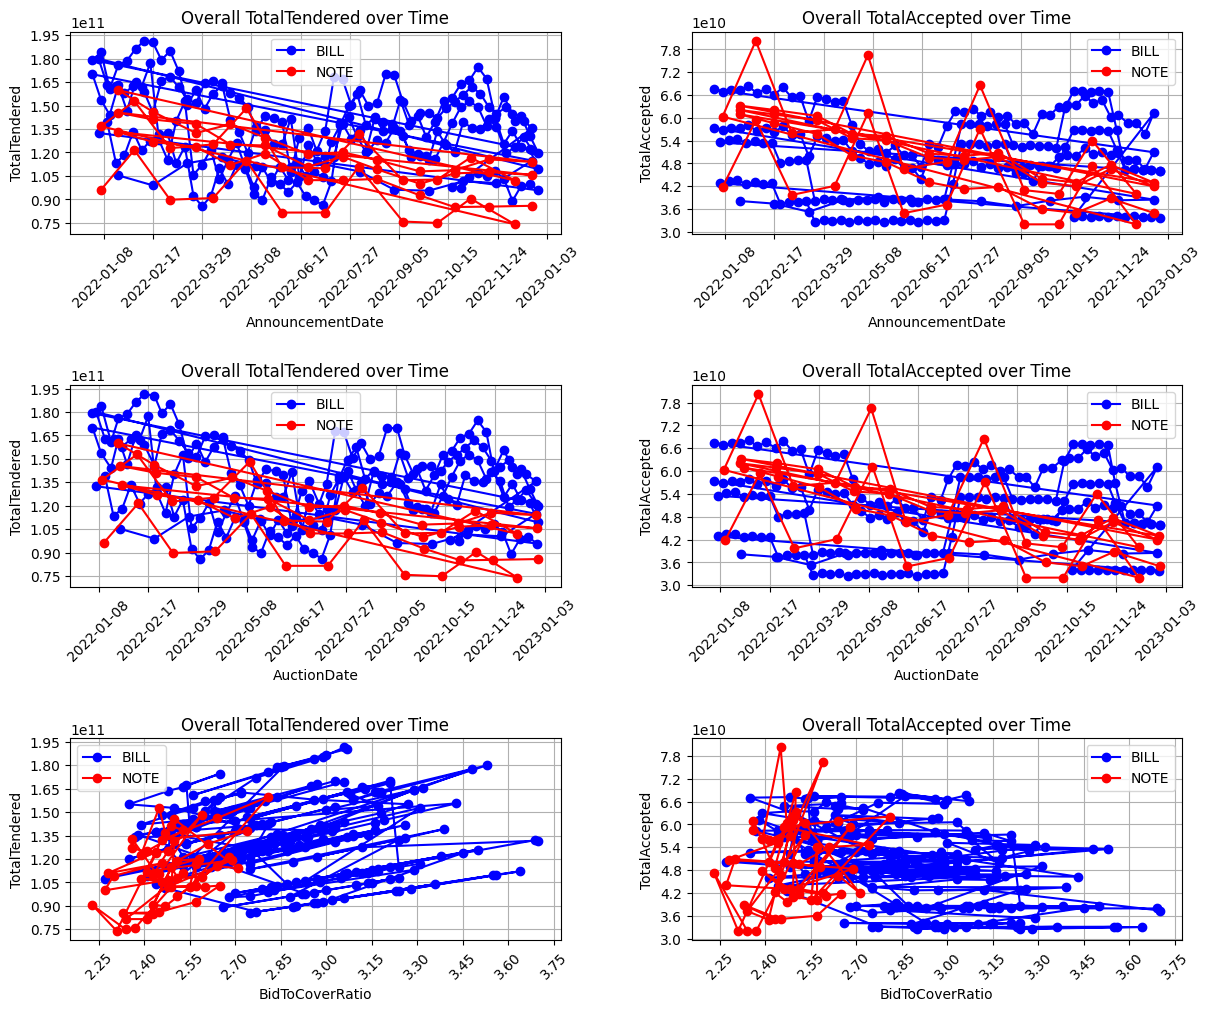

In [6]:
overallGraphsX = ['AnnouncementDate', 'AuctionDate', 'BidToCoverRatio']
overallGraphsY = ['TotalTendered', 'TotalAccepted']

# Create subplots with two columns
num_rows = len(overallGraphsX)
num_cols = len(overallGraphsY)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10), constrained_layout=True, gridspec_kw={"wspace": 0.1, "hspace": 0.1})

colors = {'BILL': 'blue', 'NOTE': 'red'}

for i, ind in enumerate(overallGraphsX):
    for j, dep in enumerate(overallGraphsY):
        ax = axes[i, j]
        
        # Plot data points for 'BILL' SecurityType
        ax.plot(dfVisual[dfVisual['SecurityType'] == 'BILL'][ind], dfVisual[dfVisual['SecurityType'] == 'BILL'][dep], 
                marker='o', linestyle='-', color=colors['BILL'], label='BILL')
        
        # Plot data points for 'NOTE' SecurityType
        ax.plot(dfVisual[dfVisual['SecurityType'] == 'NOTE'][ind], dfVisual[dfVisual['SecurityType'] == 'NOTE'][dep], 
                marker='o', linestyle='-', color=colors['NOTE'], label='NOTE')
        
        ax.set_xlabel(ind)
        ax.set_ylabel(dep)
        ax.set_title("Overall " + dep + " over Time")
        
        x_locator = MaxNLocator(nbins=12)
        ax.xaxis.set_major_locator(x_locator)
        
        y_locator = MaxNLocator(nbins=10)
        ax.yaxis.set_major_locator(y_locator)
        
        ax.tick_params(axis='x', labelrotation=45)
        ax.grid(True)
        
        ax.legend()

# Used to hide empty subplots (if any)
for i in range(num_rows):
    for j in range(num_cols):
        if (i >= len(overallGraphsX)) or (j >= len(overallGraphsY)):
            fig.delaxes(axes[i, j])

plt.show()

From the above, we make a few observations.
1. For Notes, there is a periodic relationship between the total tendered amount and the total accepted amount with the announcement date and the auction date, in which the amounts increase and decrease periodically. There is also an overall downward trend in the tendered and accepted amounts with the auction/announcement date. The relationship between the amounts and the bid to cover ratio is more difficult to capture.
2. For Bills, there is no obvious relationship between the amounts tendered/accepted with the announcement date, auction date, or bid to cover ratio. 
3. On average, the bid to cover ratios of notes are lesser than bills. 

*Bills graphs*
1. Announcement Date vs. Total Tendered
2. Annnouncement Date vs. Total Accepted
3. Auction Date vs. Total Tendered
4. Auction Date vs. Total Accepted
5. Bid to Cover Ratio vs. Total Tendered
6. Bid to Cover Ratio vs. Total Accepted
7. Investment Rate vs. Total Tendered
8. Investment Rate vs. Total Accepted

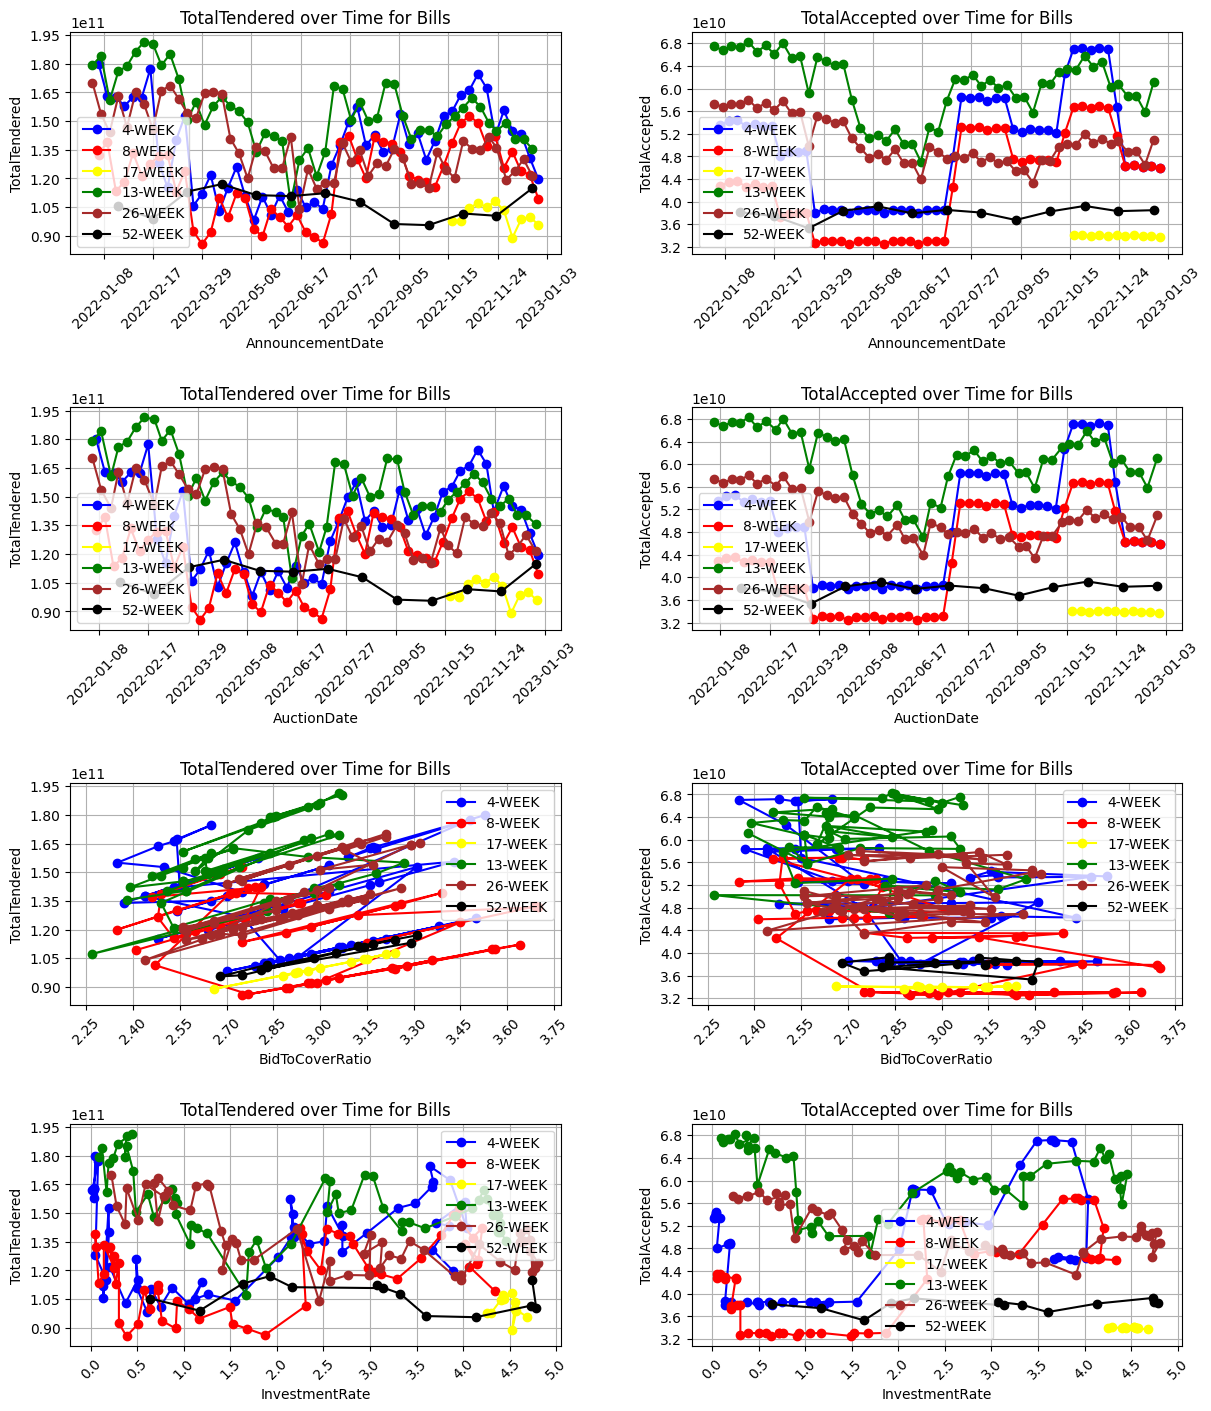

In [7]:

filtered_df = dfVisual[dfVisual['SecurityType'] == 'BILL']

overallGraphsX = ['AnnouncementDate', 'AuctionDate', 'BidToCoverRatio', 'InvestmentRate']
overallGraphsY = ['TotalTendered', 'TotalAccepted']

# Create subplots with two columns
num_rows = len(overallGraphsX)
num_cols = len(overallGraphsY)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,14), constrained_layout=True, gridspec_kw={"wspace": 0.1, "hspace": 0.1})

colors = {'4-WEEK': 'blue', '8-WEEK': 'red', '17-WEEK': 'yellow', '13-WEEK': 'green', '26-WEEK': 'brown', '52-WEEK': 'black'}

for i, ind in enumerate(overallGraphsX):
    for j, dep in enumerate(overallGraphsY):
        ax = axes[i, j]
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '4-WEEK'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '4-WEEK'][dep], 
                marker='o', linestyle='-', color=colors['4-WEEK'], label='4-WEEK')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '8-WEEK'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '8-WEEK'][dep], 
                marker='o', linestyle='-', color=colors['8-WEEK'], label='8-WEEK')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '17-WEEK'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '17-WEEK'][dep], 
                marker='o', linestyle='-', color=colors['17-WEEK'], label='17-WEEK')

        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '13-WEEK'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '13-WEEK'][dep], 
                marker='o', linestyle='-', color=colors['13-WEEK'], label='13-WEEK')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '26-WEEK'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '26-WEEK'][dep], 
                marker='o', linestyle='-', color=colors['26-WEEK'], label='26-WEEK')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '52-WEEK'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '52-WEEK'][dep], 
                marker='o', linestyle='-', color=colors['52-WEEK'], label='52-WEEK')
        
        ax.set_xlabel(ind)
        ax.set_ylabel(dep)
        ax.set_title(dep + " over Time for Bills")
        
        x_locator = MaxNLocator(nbins=12)
        ax.xaxis.set_major_locator(x_locator)
        
        y_locator = MaxNLocator(nbins=10)
        ax.yaxis.set_major_locator(y_locator)
        
        ax.tick_params(axis='x', labelrotation=45)
        ax.grid(True)
        
        ax.legend()

# Used to hide empty subplots (if any)
for i in range(num_rows):
    for j in range(num_cols):
        if (i >= len(overallGraphsX)) or (j >= len(overallGraphsY)):
            fig.delaxes(axes[i, j])

plt.show()

From the above, we make a few observations.
1. For Bills, there is an inversely proportional relationship between the term of the security and how much the tendered/accepted amounts vary either over the auction/announcement date, the bid to cover ratio, or the investment rate. This is clearly seen as the 4-week term bills are much more 'sproadic' than the 52-week term bills.
2. For certain terms within Bills where we are comparing the total accepted amounts vs. auction date/announcement date, the data can be seemingly fitted into a potential model as it mimics a square wave to a great accruacy.

*Notes graphs*
1. Announcement Date vs. Total Tendered
2. Annnouncement Date vs. Total Accepted
3. Auction Date vs. Total Tendered
4. Auction Date vs. Total Accepted
5. Bid to Cover Ratio vs. Total Tendered
6. Bid to Cover Ratio vs. Total Accepted

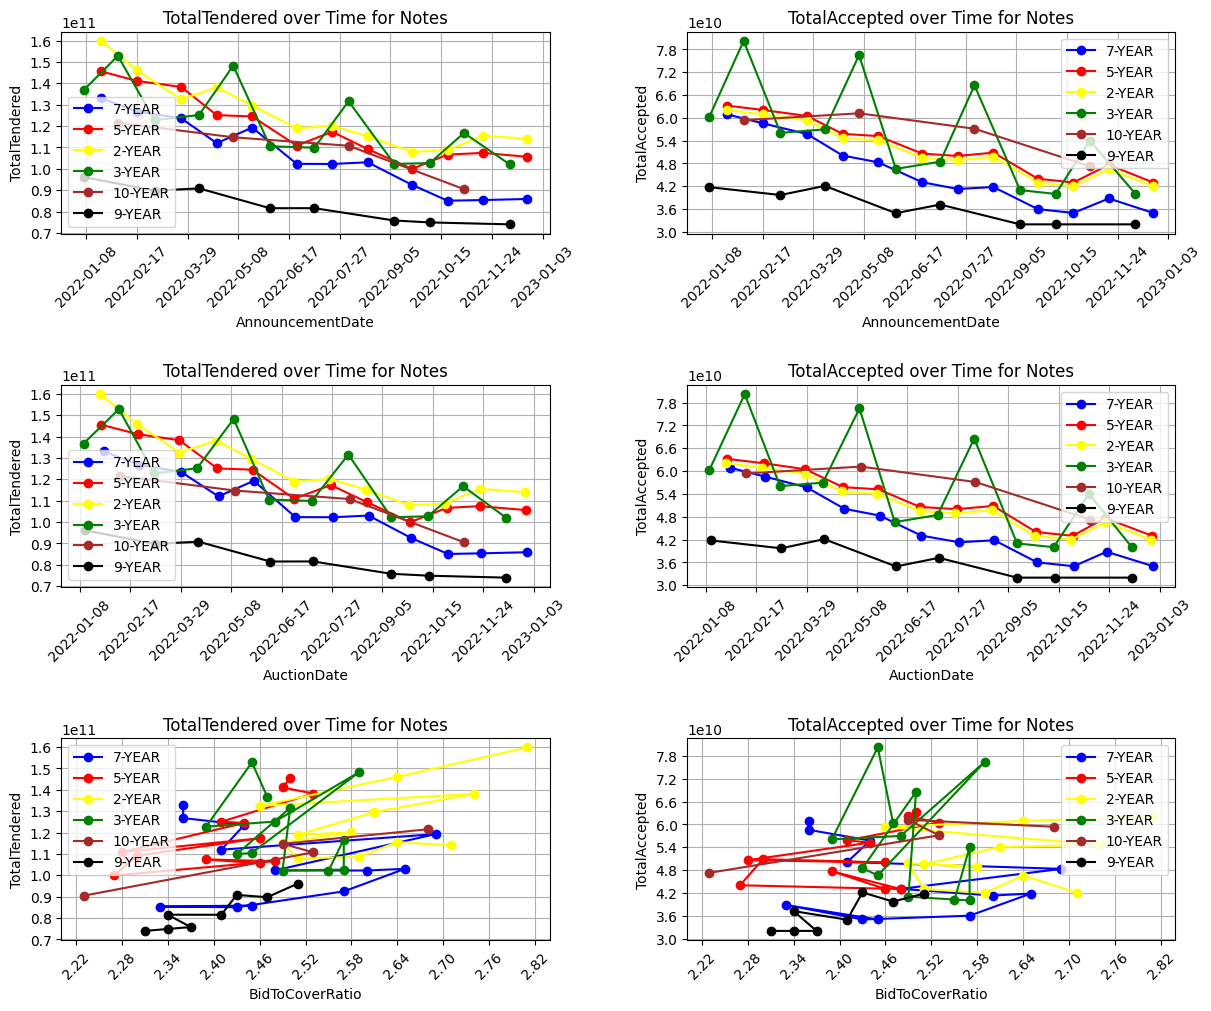

In [8]:

filtered_df = dfVisual[dfVisual['SecurityType'] == 'NOTE']

overallGraphsX = ['AnnouncementDate', 'AuctionDate', 'BidToCoverRatio']
overallGraphsY = ['TotalTendered', 'TotalAccepted']

# Create subplots with two columns
num_rows = len(overallGraphsX)
num_cols = len(overallGraphsY)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,10), constrained_layout=True, gridspec_kw={"wspace": 0.1, "hspace": 0.1})

colors = {'7-YEAR': 'blue', '5-YEAR': 'red', '2-YEAR': 'yellow', '3-YEAR': 'green', '10-YEAR': 'brown', '9-YEAR': 'black'}

for i, ind in enumerate(overallGraphsX):
    for j, dep in enumerate(overallGraphsY):
        ax = axes[i, j]
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '7-YEAR'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '7-YEAR'][dep], 
                marker='o', linestyle='-', color=colors['7-YEAR'], label='7-YEAR')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '5-YEAR'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '5-YEAR'][dep], 
                marker='o', linestyle='-', color=colors['5-YEAR'], label='5-YEAR')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '2-YEAR'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '2-YEAR'][dep], 
                marker='o', linestyle='-', color=colors['2-YEAR'], label='2-YEAR')

        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '3-YEAR'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '3-YEAR'][dep], 
                marker='o', linestyle='-', color=colors['3-YEAR'], label='3-YEAR')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '10-YEAR'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '10-YEAR'][dep], 
                marker='o', linestyle='-', color=colors['10-YEAR'], label='10-YEAR')
        
        ax.plot(filtered_df[filtered_df['SecurityTermWeekYear'] == '9-YEAR'][ind], filtered_df[filtered_df['SecurityTermWeekYear'] == '9-YEAR'][dep], 
                marker='o', linestyle='-', color=colors['9-YEAR'], label='9-YEAR')
        
        ax.set_xlabel(ind)
        ax.set_ylabel(dep)
        ax.set_title(dep + " over Time for Notes")
        
        x_locator = MaxNLocator(nbins=12)
        ax.xaxis.set_major_locator(x_locator)
        
        y_locator = MaxNLocator(nbins=10)
        ax.yaxis.set_major_locator(y_locator)
        
        ax.tick_params(axis='x', labelrotation=45)
        ax.grid(True)
        
        ax.legend()

# Used to hide empty subplots (if any)
for i in range(num_rows):
    for j in range(num_cols):
        if (i >= len(overallGraphsX)) or (j >= len(overallGraphsY)):
            fig.delaxes(axes[i, j])

plt.show()

From the above, we make a few observations.
1. For 52-week notes, on average, the total tendered/accepted amounts are lower than notes with the other terms. 
2. For Notes, the total tendered and accepted amounts decrease with the announcement date and the auction date. There is again an unusual sproadic behaviour specifically for the 3-year notes.
3. For notes, the relationship between the tendered/accepted amounts with the bid to cover ratio are harder to capture, i.e. there is close to no relationship.

*Heat maps (horizontal vs. vertical format)*
1. Different types of tendered amount (take average of amount) vs. Security Term (for Bills)
2. Different types of accepted amount (take average of amount) vs. Security Term (for Bills)
3. Different types of tendered amount (take average of amount) vs. Security Term (for Notes)
4. Different types of accepted amount (take average of amount) vs. Security Term (for Notes)

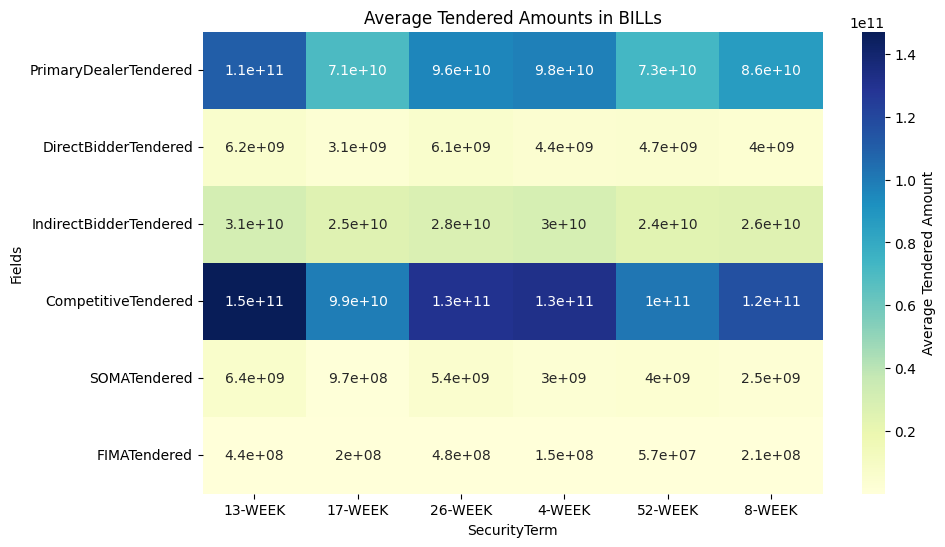

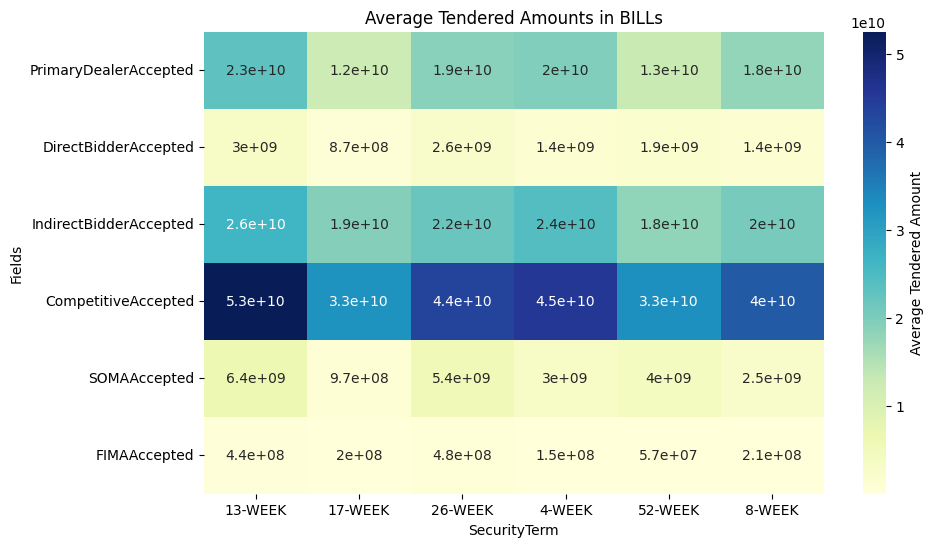

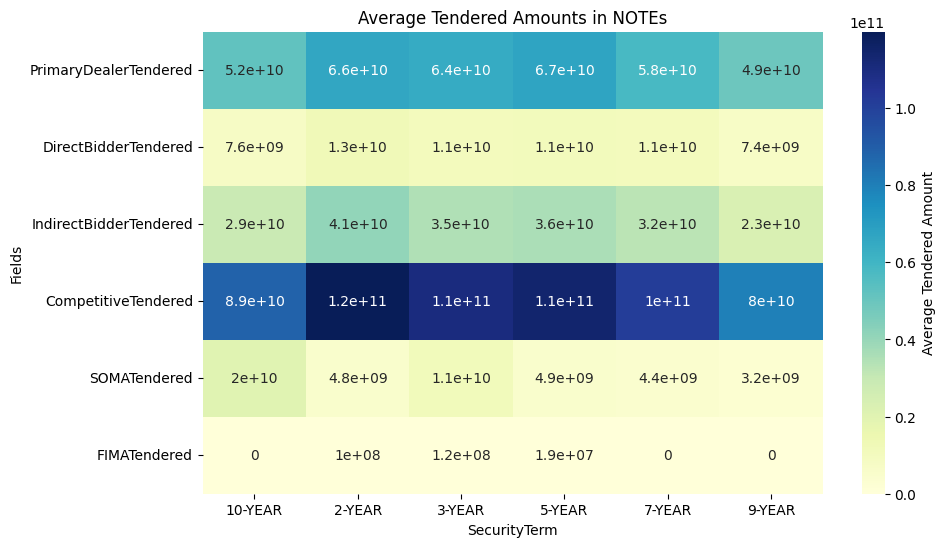

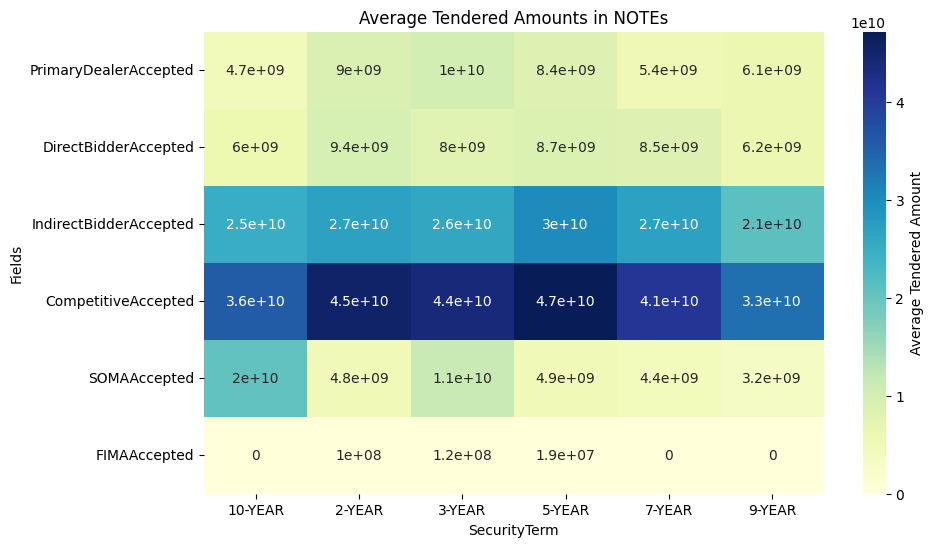

In [33]:
types = ['BILL', 'NOTE']
tendered_fields = ['PrimaryDealerTendered', 'DirectBidderTendered', 'IndirectBidderTendered', 'CompetitiveTendered', 'SOMATendered', 'FIMATendered']
accepted_fields = ['PrimaryDealerAccepted', 'DirectBidderAccepted', 'IndirectBidderAccepted', 'CompetitiveAccepted', 'SOMAAccepted', 'FIMAAccepted']
fieldType = [tendered_fields, accepted_fields]

for type in types:
    for field in fieldType:
        averages_df = dfVisual[dfVisual['SecurityType'] == type]
        averages_df = averages_df.groupby('SecurityTermWeekYear')[field].mean()

        plt.figure(figsize=(10, 6))
        sns.heatmap(averages_df.T, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Tendered Amount'})
        plt.xlabel('SecurityTerm')
        plt.ylabel('Fields')
        plt.title('Average Tendered Amounts in ' + type + "s")
        plt.show()

From the above, we make an observation.
1. In both bills and notes, the predominant factor contributing to the total tendered/accepted amounts is the competitive tendered/accepted amounts.